In [1]:
###==========================================
# Section ~ 0: Importing Libraries
###==========================================

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import os
from pathlib import Path
import shutil
import random
from tqdm import tqdm

In [4]:
from collections import Counter, defaultdict
from itertools import combinations

In [5]:
from PIL import Image
import yaml

In [6]:
import warnings

warnings.filterwarnings('ignore')

In [7]:
###==========================================
# Section ~ 1: Define Paths
###==========================================

In [8]:
project_root = Path.cwd().parent
project_root

WindowsPath('C:/Users/ADITHYA/OneDrive/Kesari')

In [9]:
dataset_dir = project_root / 'dataset'
raw_image_dir = dataset_dir / 'raw/images'
raw_label_dir = dataset_dir / 'raw/labels'
reports_figures_dir = project_root / 'reports/figures/2_data preparation'

train_dir = dataset_dir / 'train'
train_raw_images_dir = train_dir / 'raw_images'
train_raw_labels_dir = train_dir / 'raw_labels'

val_dir = dataset_dir / 'val'
val_images_dir = val_dir / 'images'
val_labels_dir = val_dir / 'labels'

test_dir = dataset_dir / 'test'
test_images_dir = test_dir / 'images'
test_labels_dir = test_dir / 'labels'

In [10]:
# Define subdirectories
subfolders = ["train", "valid", "test"]

# Create them
for sub in subfolders:
    (reports_figures_dir / sub).mkdir(parents=True, exist_ok=True)

In [11]:
train_report_dir = reports_figures_dir / "train"
valid_report_dir = reports_figures_dir / "valid"
test_report_dir = reports_figures_dir / "test"

In [12]:
###==========================================
# Section ~ 2: Create Directories
###==========================================

In [13]:
all_dirs = [
    train_raw_images_dir, train_raw_labels_dir,
    val_images_dir, val_labels_dir,
    test_images_dir, test_labels_dir,
    reports_figures_dir
]

for d in all_dirs:
    d.mkdir(parents=True, exist_ok=True)

In [14]:
###==========================================
# Section ~ 3: Load Dataset
###==========================================

In [15]:
def load_class_names_from_yaml(yaml_path: Path):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    class_names = data.get("names", [])
    return class_names

In [16]:
# Usage
data_yaml_path = project_root / "config/data.yaml"
CLASS_NAMES = load_class_names_from_yaml(data_yaml_path)

In [17]:
# Classes
NUM_CLASSES = len(CLASS_NAMES)
print(f"Loaded {NUM_CLASSES} classes:")
print(CLASS_NAMES)

Loaded 17 classes:
['tree 1-2', 'tree 10-11', 'tree 11-12', 'tree 12-13', 'tree 13-14', 'tree 14-15', 'tree 15-16', 'tree 16-17', 'tree 17-18', 'tree 18-19', 'tree 2-3', 'tree 3-4', 'tree 4-5', 'tree 5-6', 'tree 6-7', 'tree 7-8', 'tree 9-10']


In [18]:
# Define allowed image extensions
allowed_image_exts = {'.png', '.jpg', '.jpeg'}

# Filter image files by extension
image_files = sorted([f for f in raw_image_dir.glob('*') if f.suffix.lower() in allowed_image_exts])
label_files = sorted(raw_label_dir.glob('*'))  # Assuming labels can be any format

# Get stem names
image_names = {img.stem for img in image_files}
label_names = {lbl.stem for lbl in label_files}

# Comparison
labeled = sorted(image_names & label_names)
unlabeled = sorted(image_names - label_names)
extra_labels = sorted(label_names - image_names)

# Reporting
total_images = len(image_names)
total_labels = len(label_names)

In [19]:
print("----- Labeling Report -----\n")
print(f"  -- Total images: {total_images}")
print(f"  -- Total label files: {total_labels}")
print(f"  -- Images with labels: {len(labeled)} ({(len(labeled)/total_images)*100:.2f}%)")
print(f"  -- Images without labels: {len(unlabeled)} ({(len(unlabeled)/total_images)*100:.2f}%)")
print(f"  -- Labels without corresponding images: {len(extra_labels)}")

----- Labeling Report -----

  -- Total images: 301
  -- Total label files: 301
  -- Images with labels: 301 (100.00%)
  -- Images without labels: 0 (0.00%)
  -- Labels without corresponding images: 0


In [20]:
###===========================================
# Section ~ 3: Categorize Images by Label Content
###===========================================

In [21]:
# Categorized lists
labeled_images = []
test_images = []

In [22]:
# Categorize based on label content
for image_file in image_files:
    stem = image_file.stem
    label_file = raw_label_dir / f"{stem}.txt"  # You can change to .json or .xml if needed

    if label_file.exists() and label_file.stat().st_size > 0:
        labeled_images.append(stem)
    else:
        test_images.append(stem)

In [23]:
# Reporting
total = len(image_files)
labeled_count = len(labeled_images)
test_count = len(test_images)

In [24]:
print("----- Image Label Categorization -----")
print(f"  -- Total images: {total}")
print(f"  -- Images with valid labels: {labeled_count} ({(labeled_count/total)*100:.2f}%)")
print(f"  -- Images with empty labels: {test_count} ({(test_count/total)*100:.2f}%)")

----- Image Label Categorization -----
  -- Total images: 301
  -- Images with valid labels: 269 (89.37%)
  -- Images with empty labels: 32 (10.63%)


In [25]:
###==========================================
# Section ~ 4: Split the labeled images
###==========================================

In [26]:
random.seed(42)
random.shuffle(labeled_images)

In [27]:
# Split labeled into train & val only
total_labeled = len(labeled_images)  # 269
train_size = int(total_labeled * 0.75)  # ~201
val_size = total_labeled - train_size   # ~68

In [28]:
# Split
train_set = labeled_images[:train_size]
val_set = labeled_images[train_size:]

# Test set is just the unlabeled/empty-label images
test_set = test_images

In [29]:
# Print stats
print("----- Dataset Split Summary -----\n")
print(f"Total labeled images: {total_labeled}")
print(f"Train set: {len(train_set)} ({(len(train_set)/total_labeled)*100:.2f}%)")
print(f"Validation set: {len(val_set)} ({(len(val_set)/total_labeled)*100:.2f}%)")
print(f"Test set: {len(test_set)}")

----- Dataset Split Summary -----

Total labeled images: 269
Train set: 201 (74.72%)
Validation set: 68 (25.28%)
Test set: 32


In [30]:
###==========================================
# Section ~ 5: Copy images and labels
###==========================================

In [31]:
def copy_files(stems, img_dst, lbl_dst=None):
    img_dst.mkdir(parents=True, exist_ok=True)
    if lbl_dst:
        lbl_dst.mkdir(parents=True, exist_ok=True)

    supported_img_exts = ['.jpg', '.jpeg', '.png']
    for stem in stems:
        # Try all supported image extensions
        img_path = next((raw_image_dir / f"{stem}{ext}" for ext in supported_img_exts if (raw_image_dir / f"{stem}{ext}").exists()), None)
        if img_path and img_path.exists():
            shutil.copy(img_path, img_dst / img_path.name)

        # Only copy label if it's non-empty and exists
        if lbl_dst:
            lbl_path = raw_label_dir / f"{stem}.txt"
            if lbl_path.exists() and lbl_path.stat().st_size > 0:
                shutil.copy(lbl_path, lbl_dst / lbl_path.name)

In [32]:
# Copying the images and labels
copy_files(train_set, train_raw_images_dir, train_raw_labels_dir)
copy_files(val_set, val_images_dir, val_labels_dir)
copy_files(test_set, test_images_dir)

In [33]:
def count_files(img_dir, lbl_dir, img_exts={'.jpg', '.jpeg', '.png'}, lbl_exts={'.txt'}):
    img_count = len([f for f in img_dir.glob('*') if f.suffix.lower() in img_exts])
    lbl_count = 0
    for lbl_file in lbl_dir.glob('*'):
        if lbl_file.suffix.lower() in lbl_exts and lbl_file.stat().st_size > 0:  # Only count non-empty label files
            lbl_count += 1
    return img_count, lbl_count

In [34]:
# Count image/label files
train_img, train_lbl = count_files(train_raw_images_dir, train_raw_labels_dir)
val_img, val_lbl = count_files(val_images_dir, val_labels_dir)
test_img, test_lbl = count_files(test_images_dir, test_labels_dir)

In [35]:
train_img, train_lbl

(201, 201)

In [36]:
val_img, val_lbl

(68, 68)

In [37]:
test_img, test_lbl

(32, 0)

In [38]:
# Print summary
print("📊 ===== Dataset Split Summary =====\n")
print(f"{'Split':<10}{'Images':>10}{'Labels':>10}{'Label %':>12}")
print("-" * 42)
splits_info = [
    ("Train", train_img, train_lbl),
    ("Validation", val_img, val_lbl),
    ("Test", test_img, test_lbl)
]
for name, img, lbl in splits_info:
    label_pct = (lbl / img * 100) if img > 0 else 0
    print(f"{name:<10}{img:>10}{lbl:>10}{label_pct:>11.2f} %")
print("-" * 42)
total_img = train_img + val_img + test_img
total_lbl = train_lbl + val_lbl + test_lbl
total_pct = (total_lbl / total_img * 100) if total_img > 0 else 0
print(f"{'Total':<10}{total_img:>10}{total_lbl:>10}{total_pct:>11.2f} %")

📊 ===== Dataset Split Summary =====

Split         Images    Labels     Label %
------------------------------------------
Train            201       201     100.00 %
Validation        68        68     100.00 %
Test              32         0       0.00 %
------------------------------------------
Total            301       269      89.37 %


In [39]:
###==========================================
# Section ~ 7: Visualize Dataset Splits
###==========================================

In [40]:
# Visualization setup
colors = ['skyblue', 'orange', 'lightgreen']
splits = ['Train', 'Validation', 'Test']
img_counts = [train_img, val_img, test_img]
lbl_counts = [train_lbl, val_lbl, test_lbl]
label_percents = [round(lbl / img * 100, 2) if img else 0 for img, lbl in zip(img_counts, lbl_counts)]

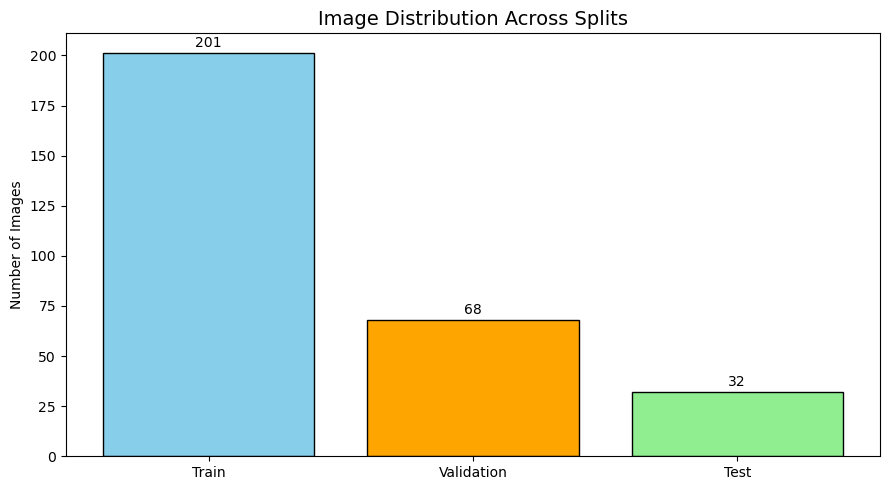

In [41]:
# --- Bar Chart: Image Count per Split ---
plt.figure(figsize=(9, 5))
bars = plt.bar(splits, img_counts, color=colors, edgecolor='black')
plt.title("Image Distribution Across Splits", fontsize=14)
plt.ylabel("Number of Images")

for bar, count in zip(bars, img_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 3, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(reports_figures_dir / 'dataset_split_distribution_bar.png', dpi=300)
plt.show()

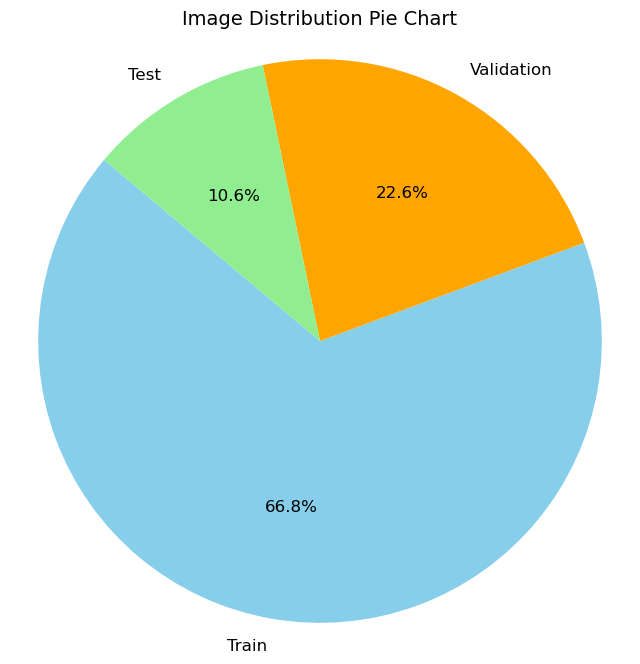

In [42]:
# --- Pie Chart: Image Split Proportion ---
plt.figure(figsize=(8, 8))
plt.pie(img_counts, labels=splits, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 12})
plt.title("Image Distribution Pie Chart", fontsize=14)
plt.axis('equal')  # Circle

plt.savefig(reports_figures_dir / 'dataset_split_distribution_pie.png', dpi=300)
plt.show()

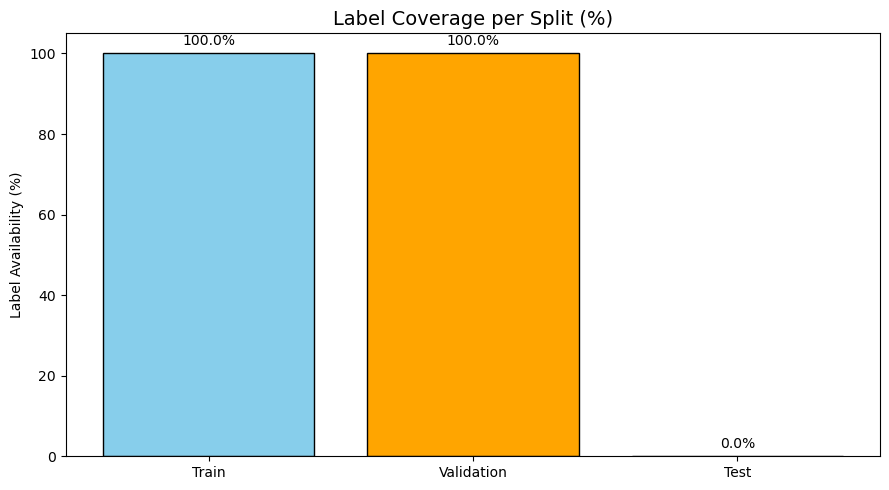

In [43]:
# --- Bar Chart: Label Coverage per Split ---
plt.figure(figsize=(9, 5))
bars = plt.bar(splits, label_percents, color=colors, edgecolor='black')
plt.title("Label Coverage per Split (%)", fontsize=14)
plt.ylabel("Label Availability (%)")
plt.ylim(0, 105)

for bar, pct in zip(bars, label_percents):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f"{pct:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(reports_figures_dir / 'label_coverage_per_split.png', dpi=300)
plt.show()

In [44]:
###==========================================
# Section ~ 8: Image Property Analysis
###==========================================

In [45]:
# Function to Parse YOLO Labels for Classes
def parse_yolo_labels_for_classes(label_dir: Path, num_expected_classes: int):
    class_ids = []
    invalid = defaultdict(list)

    for file in tqdm(label_dir.glob("*.txt"), desc=f"Class Distribution in {label_dir.name}"):
        try:
            with open(file) as f:
                for line_num, line in enumerate(f, 1):
                    parts = line.strip().split()
                    if parts:
                        try:
                            class_id = int(parts[0])
                            if 0 <= class_id < num_expected_classes:
                                class_ids.append(class_id)
                            else:
                                invalid[file.name].append(f"line {line_num}: id {class_id} out of range")
                        except ValueError:
                            invalid[file.name].append(f"line {line_num}: {parts[0]} is not a valid integer")
        except Exception as e:
            invalid[file.name].append(f"read error: {e}")
    return class_ids, dict(invalid)

In [46]:
# Function to Get Bounding Box Stats (Objects and Aspect Ratios)
def get_bounding_box_stats(label_dir: Path):
    objects_per_image = []
    bbox_ratios = []

    for label_file in tqdm(label_dir.glob("*.txt"), desc=f"Bounding Box Stats in {label_dir.name}"):
        try:
            with open(label_file) as f:
                lines = [line.strip() for line in f if line.strip()]
                objects_per_image.append(len(lines))
                for line in lines:
                    parts = line.split()
                    if len(parts) >= 5:
                        w, h = float(parts[3]), float(parts[4])
                        bbox_ratios.append(w / h if h != 0 else 0)
        except Exception as e:
            print(f"⚠️ {label_file.name}: {e}")

    return objects_per_image, bbox_ratios

In [47]:
# Function to visualize Class Distribution and Bounding Box Stats
def visualize_class_distribution(class_ids, name):
    class_counts = Counter(class_ids)
    class_labels = sorted(class_counts.keys())
    class_frequencies = [class_counts[label] for label in class_labels]

    # Plot Class Distribution
    plt.figure(figsize=(8, 5))
    plt.bar(class_labels, class_frequencies, color='skyblue')
    plt.title(f"Class Distribution in {name} Set")
    plt.xlabel('Class ID')
    plt.ylabel('Frequency')
    plt.xticks(class_labels)
    plt.tight_layout()
    plt.show()

In [48]:
# Function to plot bounding box stats
def plot_bounding_box_stats(objects_per_image, bbox_ratios, name):
    # Plot Objects per Image Distribution
    plt.figure(figsize=(8, 5))
    plt.hist(objects_per_image, bins=30, color='lightgreen', edgecolor='black')
    plt.title(f"Objects per Image - {name} Set")
    plt.xlabel('Number of Objects per Image')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Plot Aspect Ratio Distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(bbox_ratios, kde=True, bins=30, color='salmon', edgecolor='black')
    plt.title(f"Bounding Box Aspect Ratios - {name} Set")
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

🔍 Analyzing Train Labels...



Class Distribution in raw_labels: 201it [00:00, 324.80it/s]
Bounding Box Stats in raw_labels: 201it [00:00, 3079.23it/s]


Total class IDs parsed: 201
Invalid label files: 0
Objects per image: Mean=1.00, Max=1, Min=1, Std=0.00
Aspect Ratios: Mean=1.34, Median=1.30, Sample=[2.104116222760291, 1.3859154929577466, 1.355421686746988, 1.2577030812324927, 1.9369085173501577], Std=0.28


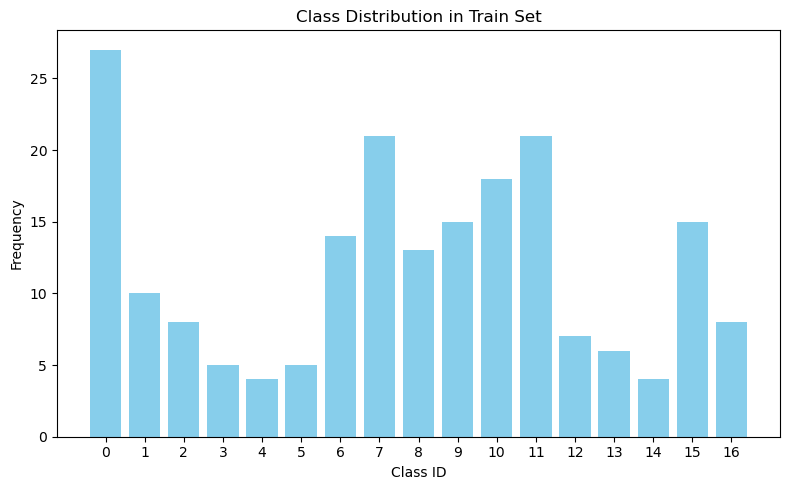

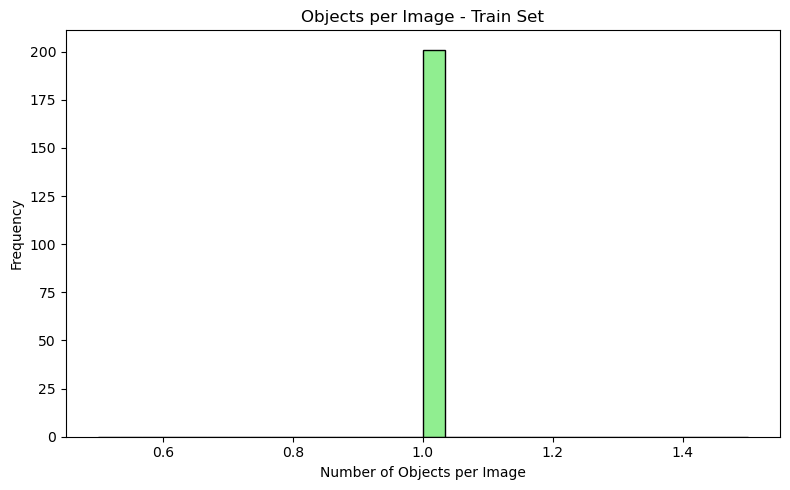

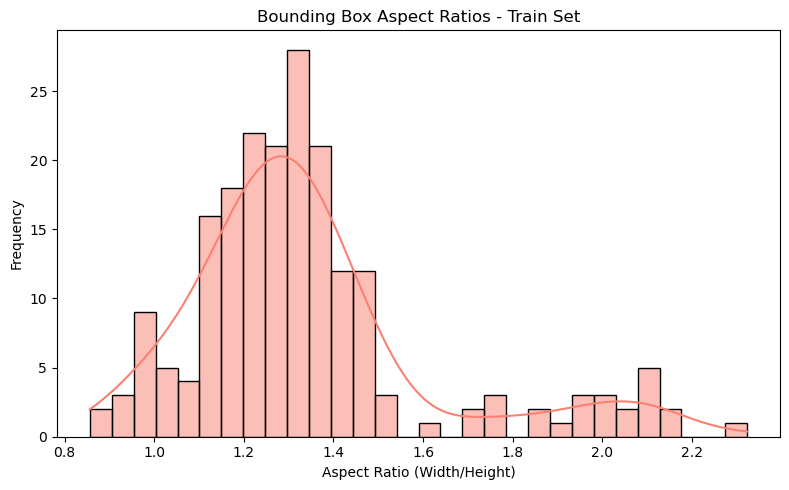

🔍 Analyzing Validation Labels...



Class Distribution in labels: 68it [00:00, 254.23it/s]
Bounding Box Stats in labels: 68it [00:00, 1516.52it/s]


Total class IDs parsed: 69
Invalid label files: 0
Objects per image: Mean=1.01, Max=2, Min=1, Std=0.12
Aspect Ratios: Mean=1.37, Median=1.35, Sample=[2.2559241706161135, 2.166377816291161, 1.861861861861862, 1.8991097922848663, 1.8362573099415203], Std=0.36


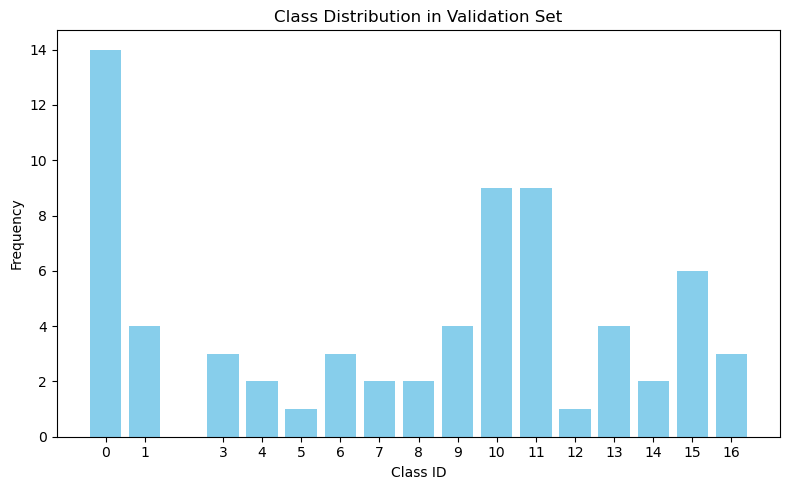

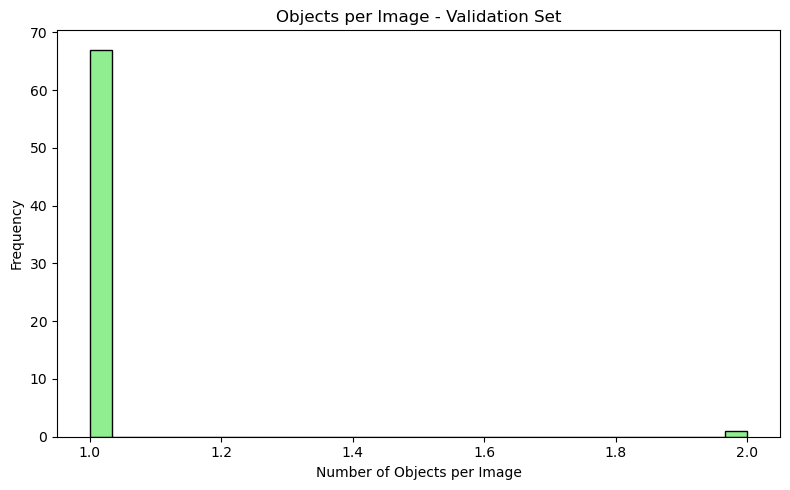

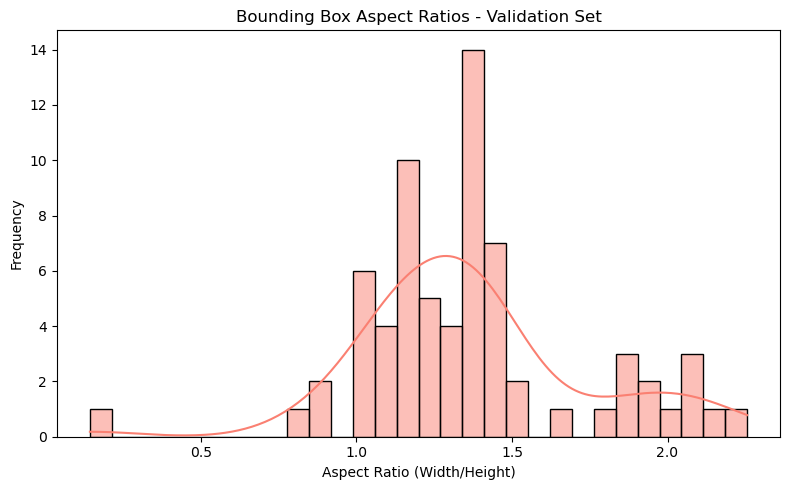

🔍 Analyzing Test Labels...



Class Distribution in labels: 32it [00:00, 2886.09it/s]
Bounding Box Stats in labels: 32it [00:00, 3064.96it/s]

Total class IDs parsed: 0
Invalid label files: 0
Objects per image: Mean=0.00, Max=0, Min=0, Std=0.00
Aspect Ratios: Mean=nan, Median=nan, Sample=[], Std=nan


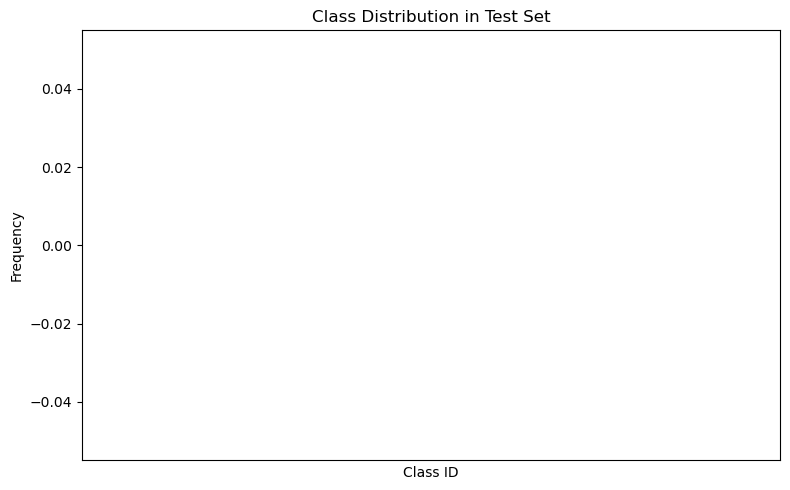

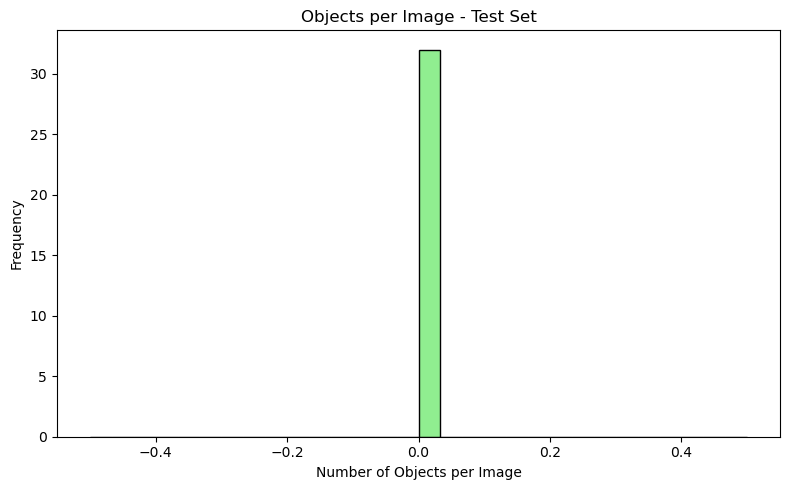

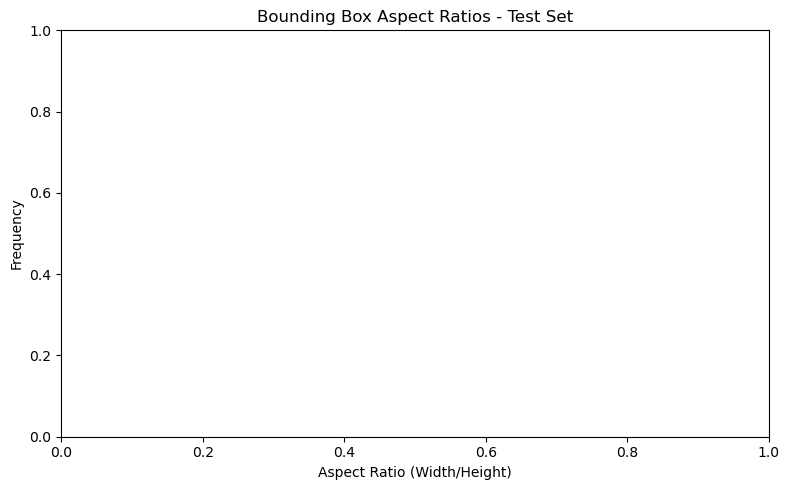

In [49]:
# Loop through Train, Validation, and Test Sets
for name, lbl_dir in [("Train", train_raw_labels_dir),
                      ("Validation", val_labels_dir),
                      ("Test", test_labels_dir)]:
    NUM_CLASSES = 17  # Assuming 10 classes for this dataset
    
    print(f"🔍 Analyzing {name} Labels...\n")

    # Parse YOLO labels for valid class IDs
    class_ids, invalids = parse_yolo_labels_for_classes(lbl_dir, NUM_CLASSES)
    objects_per_image, aspect_ratios = get_bounding_box_stats(lbl_dir)

    # Print summary of findings
    print(f"Total class IDs parsed: {len(class_ids)}")
    print(f"Invalid label files: {len(invalids)}")
    print(f"Objects per image: Mean={np.mean(objects_per_image):.2f}, Max={max(objects_per_image, default=0)}, "
          f"Min={min(objects_per_image, default=0)}, Std={np.std(objects_per_image):.2f}")
    print(f"Aspect Ratios: Mean={np.mean(aspect_ratios):.2f}, Median={np.median(aspect_ratios):.2f}, "
          f"Sample={aspect_ratios[:5]}, Std={np.std(aspect_ratios):.2f}")

    # Visualize class distribution and bounding box stats
    visualize_class_distribution(class_ids, name)
    plot_bounding_box_stats(objects_per_image, aspect_ratios, name)

In [50]:
# ============================
# Bounding Box Distribution
# ============================

In [51]:
def analyze_additional_bbox_stats(label_dir: Path, class_names: list[str], image_size=(640, 640), save_dir: Path = None):
    """
    Analyzes bounding box stats including class distribution, bounding box area, and heatmap.

    :param label_dir: Directory containing label files (.txt)
    :param class_names: List of class names for the dataset
    :param image_size: Tuple representing the image size (width, height)
    :param save_dir: Directory to save the generated plots
    """
    class_counts = defaultdict(int)
    bbox_areas = []
    heatmap = np.zeros(image_size)

    print(f"Analyzing bounding boxes in: {label_dir}")

    for label_file in tqdm(sorted(label_dir.glob("*.txt"))):
        with open(label_file, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue

            class_id, x_center, y_center, width, height = map(float, parts[:5])
            class_counts[int(class_id)] += 1
            bbox_areas.append(width * height)

            px = int(x_center * image_size[0])
            py = int(y_center * image_size[1])
            if 0 <= px < image_size[0] and 0 <= py < image_size[1]:
                heatmap[py, px] += 1

    # Class frequency bar plot
    plt.figure(figsize=(10, 6))
    labels = [class_names[i] if i < len(class_names) else f"Class {i}" for i in class_counts.keys()]
    sns.barplot(x=labels, y=list(class_counts.values()), palette="viridis")
    plt.title("Class Frequency Distribution")
    plt.xlabel("Class")
    plt.ylabel("Instances")
    plt.xticks(rotation=45)
    plt.tight_layout()
    if save_dir:
        plt.savefig(save_dir / "class_distribution.png")
    plt.show()

    # Bounding box area distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(bbox_areas, bins=30, kde=True, color="green")
    plt.title("Bounding Box Area Distribution")
    plt.xlabel("Area (YOLO format)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    if save_dir:
        plt.savefig(save_dir / "bbox_area_distribution.png")
    plt.show()

    # Bounding box heatmap
    plt.figure(figsize=(8, 8))
    sns.heatmap(heatmap, cmap="hot", cbar=True)
    plt.title("Bounding Box Center Heatmap")
    plt.xlabel("X-axis (relative to image size)")
    plt.ylabel("Y-axis (relative to image size)")
    plt.tight_layout()
    if save_dir:
        plt.savefig(save_dir / "bbox_heatmap.png")
    plt.show()

In [52]:
# ============================
# Channel Mean/Std Statistics
# ============================

In [53]:
def compute_image_channel_stats(image_dir: Path, sample_limit: int = None):
    """
    Computes mean and standard deviation for each color channel (RGB).

    :param image_dir: Directory containing image files
    :param sample_limit: Maximum number of images to sample
    """
    print(f"Computing channel statistics in: {image_dir}")
    image_paths = list(image_dir.glob("*"))
    if sample_limit:
        image_paths = image_paths[:sample_limit]

    r_vals, g_vals, b_vals = [], [], []

    for img_path in tqdm(image_paths):
        try:
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img).astype(np.float32) / 255.0
            r, g, b = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]
            r_vals.append(r.mean())
            g_vals.append(g.mean())
            b_vals.append(b.mean())
        except Exception as e:
            print(f"Error reading {img_path.name}: {e}")

    print("Channel Statistics:")
    print(f"Red   - Mean: {np.mean(r_vals):.4f}, Std: {np.std(r_vals):.4f}")
    print(f"Green - Mean: {np.mean(g_vals):.4f}, Std: {np.std(g_vals):.4f}")
    print(f"Blue  - Mean: {np.mean(b_vals):.4f}, Std: {np.std(b_vals):.4f}")

In [54]:
# ============================
# Label/Image Alignment Check
# ============================

In [55]:
def check_label_image_alignment(image_dir: Path, label_dir: Path):
    """
    Checks the alignment between images and labels in the provided directories.

    :param image_dir: Directory containing images
    :param label_dir: Directory containing labels
    """
    print(f"Checking alignment between images and labels in: {image_dir} and {label_dir}")

    image_stems = {p.stem for p in image_dir.glob("*") if p.suffix.lower() in ['.jpg', '.jpeg', '.png']}
    label_stems = {p.stem for p in label_dir.glob("*.txt")}

    missing_labels = image_stems - label_stems
    missing_images = label_stems - image_stems

    print(f"Images without labels: {len(missing_labels)}")
    print(f"Labels without images: {len(missing_images)}")

    if missing_labels:
        print("Sample image(s) without label:", list(missing_labels)[:5])
    if missing_images:
        print("Sample label(s) without image:", list(missing_images)[:5])

In [56]:
# ============================
# Bounding Box Center Density
# ============================

In [57]:
def bbox_position_density(label_dir: Path, save_dir: Path = None):
    """
    Analyzes the density of bounding box centers across the images.

    :param label_dir: Directory containing label files
    :param save_dir: Directory to save the generated plots
    """
    x_centers, y_centers = [], []

    for label_file in label_dir.glob("*.txt"):
        with open(label_file, "r") as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            _, x, y, _, _ = map(float, parts[:5])
            x_centers.append(x)
            y_centers.append(y)

    for centers, axis_name in [(x_centers, "X"), (y_centers, "Y")]:
        plt.figure(figsize=(10, 5))
        sns.histplot(centers, bins=50, kde=True, color='purple')
        plt.title(f"BBox Center {axis_name}-Position Distribution")
        plt.xlabel(f"{axis_name}-center (relative)")
        plt.ylabel("Frequency")
        plt.tight_layout()
        if save_dir:
            plt.savefig(save_dir / f"bbox_center_{axis_name.lower()}_distribution.png")
        plt.show()

In [58]:
# ============================
# Running Full Dataset Analysis
# ============================

In [59]:
def run_dataset_analysis(image_dir, label_dir, class_names, report_dir, sample_limit=None, image_size=(640, 640)):
    """
    Runs a full analysis for a given dataset (Train/Validation/Test).

    :param image_dir: Path to the image directory
    :param label_dir: Path to the label directory
    :param class_names: List of class names
    :param report_dir: Directory where the reports should be saved
    :param sample_limit: Maximum number of images to sample for channel stats
    :param image_size: The size of the images used for bounding box heatmap and other stats
    """
    # Check if image-label alignment is correct
    print(f"\n--- Running analysis for {image_dir.name} dataset ---")
    check_label_image_alignment(image_dir, label_dir)

    # Analyze additional bounding box stats (class distribution, bbox area, heatmap)
    analyze_additional_bbox_stats(label_dir, class_names, image_size=image_size, save_dir=report_dir)

    # Compute channel statistics for the dataset (mean, std)
    compute_image_channel_stats(image_dir, sample_limit=sample_limit)

    # Analyze bounding box center density distribution
    bbox_position_density(label_dir, save_dir=report_dir)


--- Running analysis for raw_images dataset ---
Checking alignment between images and labels in: C:\Users\ADITHYA\OneDrive\Kesari\dataset\train\raw_images and C:\Users\ADITHYA\OneDrive\Kesari\dataset\train\raw_labels
Images without labels: 0
Labels without images: 0
Analyzing bounding boxes in: C:\Users\ADITHYA\OneDrive\Kesari\dataset\train\raw_labels


100%|██████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 3185.13it/s]


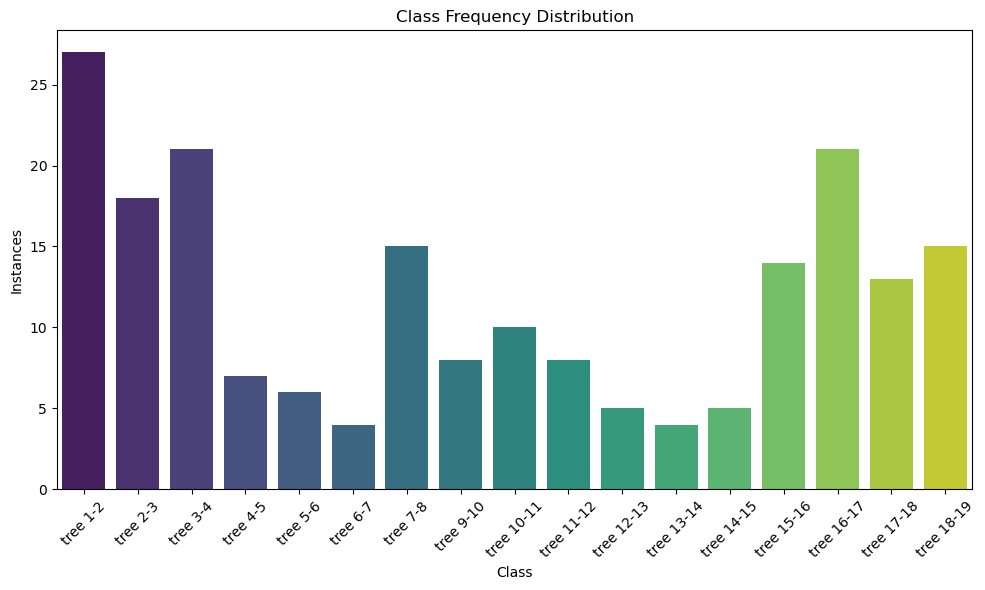

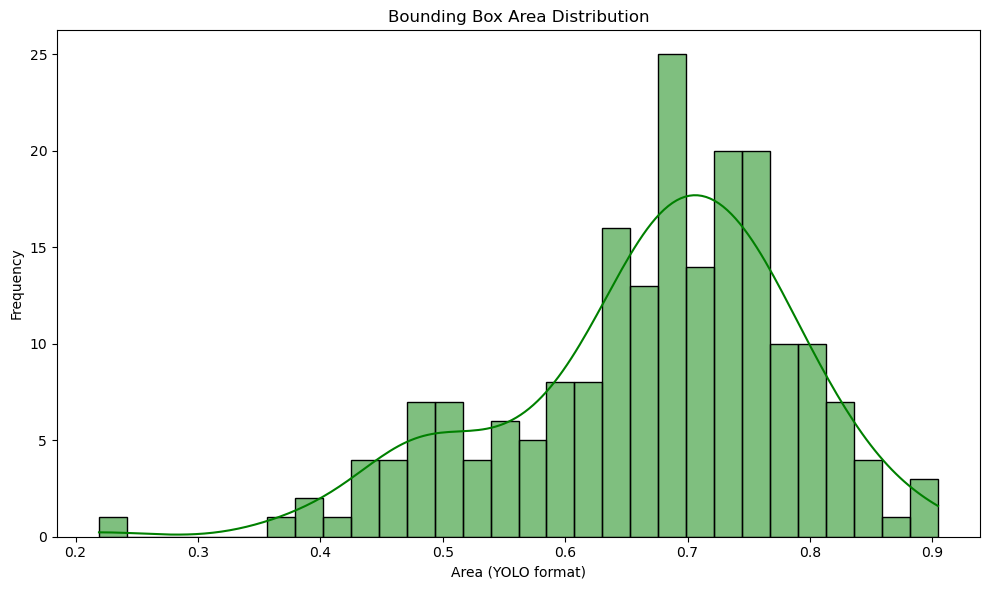

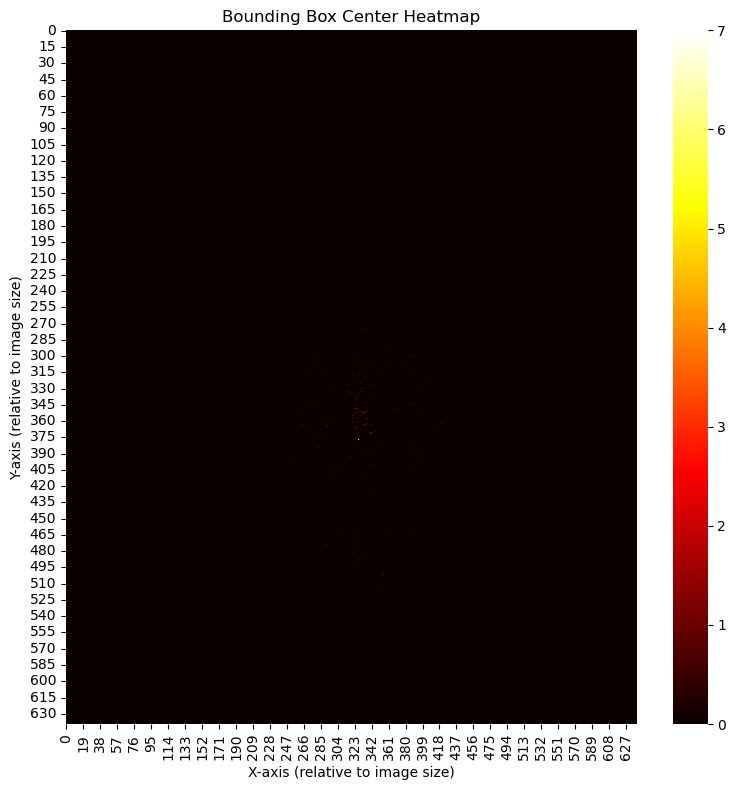

Computing channel statistics in: C:\Users\ADITHYA\OneDrive\Kesari\dataset\train\raw_images


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:09<00:00, 21.85it/s]


Channel Statistics:
Red   - Mean: 0.4488, Std: 0.0235
Green - Mean: 0.4526, Std: 0.0176
Blue  - Mean: 0.3746, Std: 0.0378


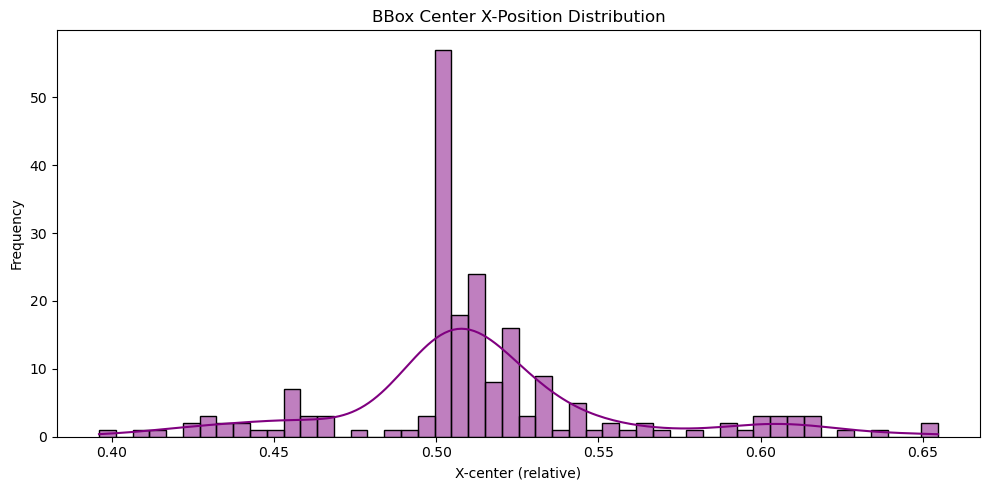

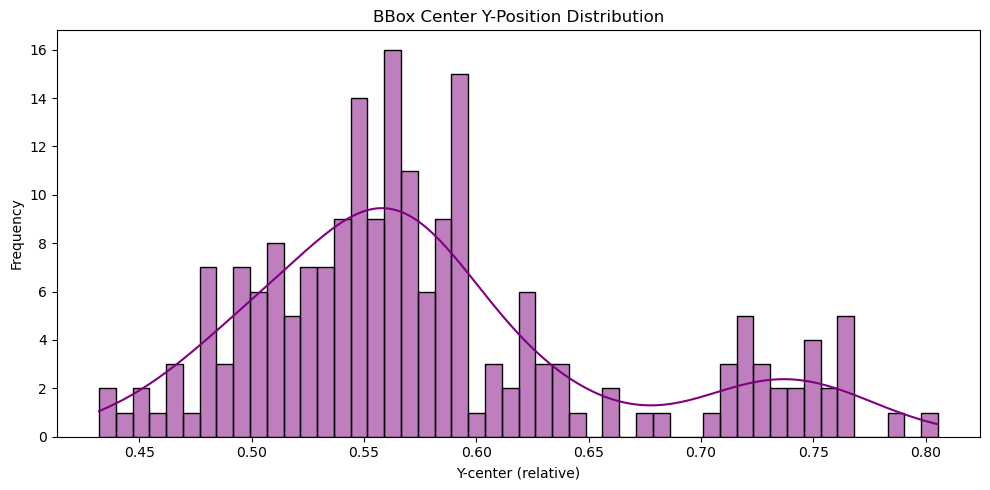

In [60]:
# Run analysis for all datasets with customized parameters
run_dataset_analysis(train_raw_images_dir, train_raw_labels_dir, CLASS_NAMES, train_report_dir, image_size=(640, 640))


--- Running analysis for images dataset ---
Checking alignment between images and labels in: C:\Users\ADITHYA\OneDrive\Kesari\dataset\test\images and C:\Users\ADITHYA\OneDrive\Kesari\dataset\test\labels
Images without labels: 0
Labels without images: 0
Analyzing bounding boxes in: C:\Users\ADITHYA\OneDrive\Kesari\dataset\test\labels


100%|████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 4078.82it/s]


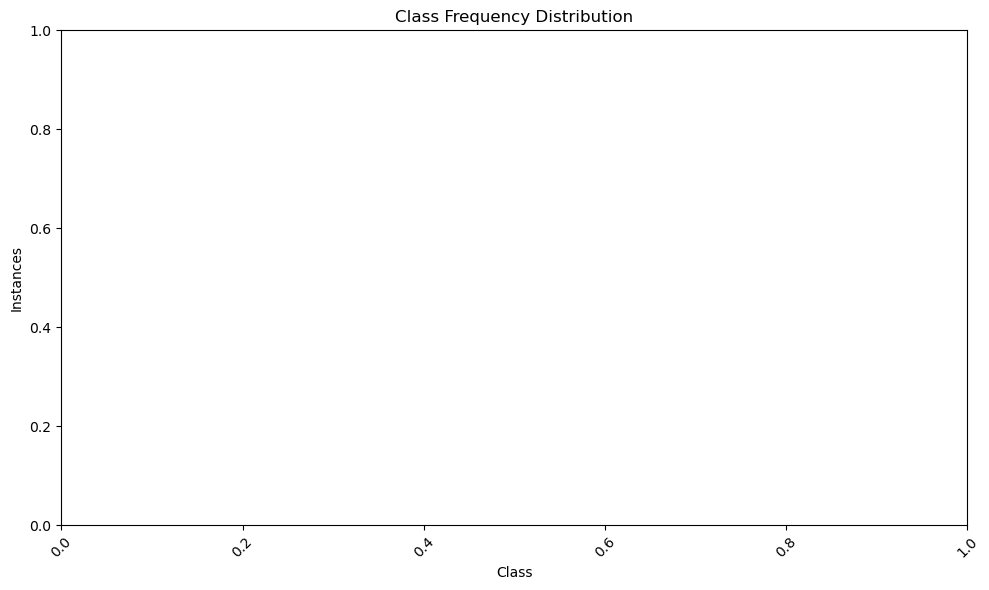

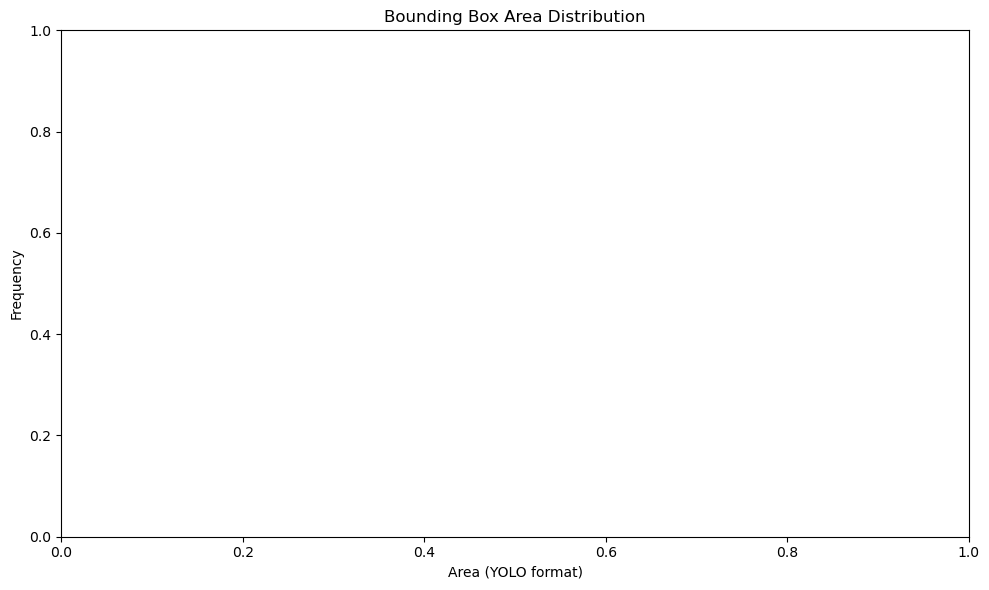

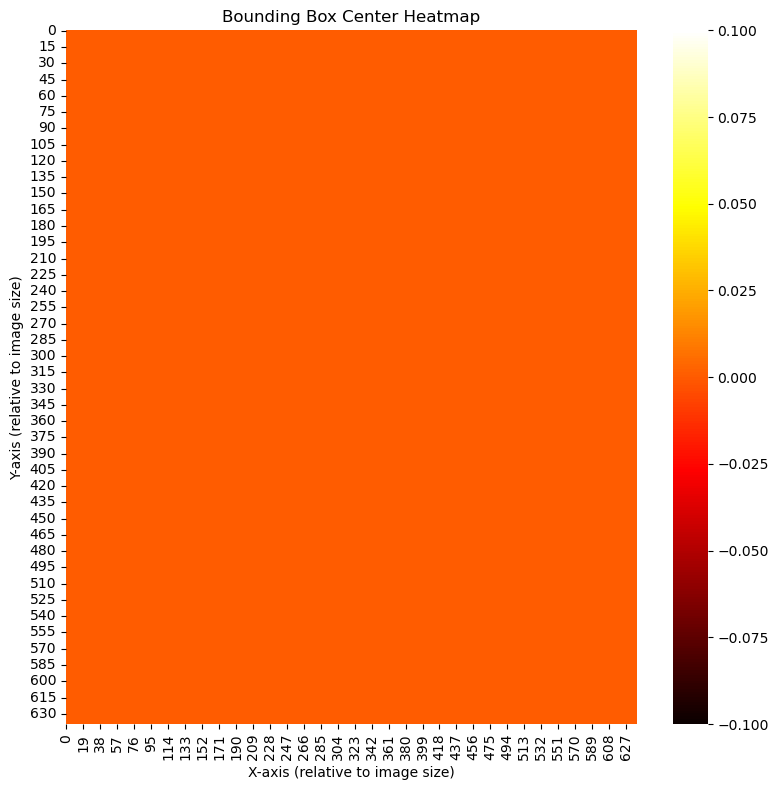

Computing channel statistics in: C:\Users\ADITHYA\OneDrive\Kesari\dataset\test\images


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 20.55it/s]


Channel Statistics:
Red   - Mean: 0.4379, Std: 0.0241
Green - Mean: 0.4451, Std: 0.0156
Blue  - Mean: 0.3451, Std: 0.0212


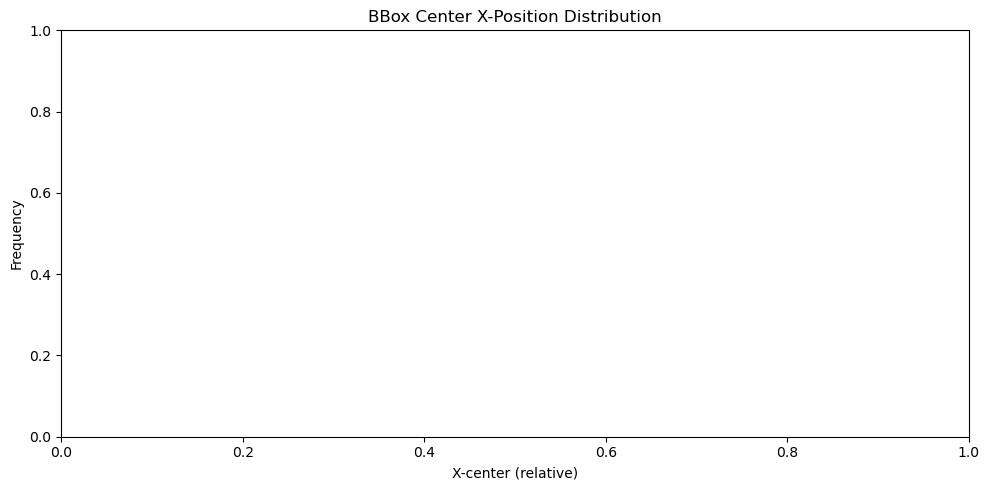

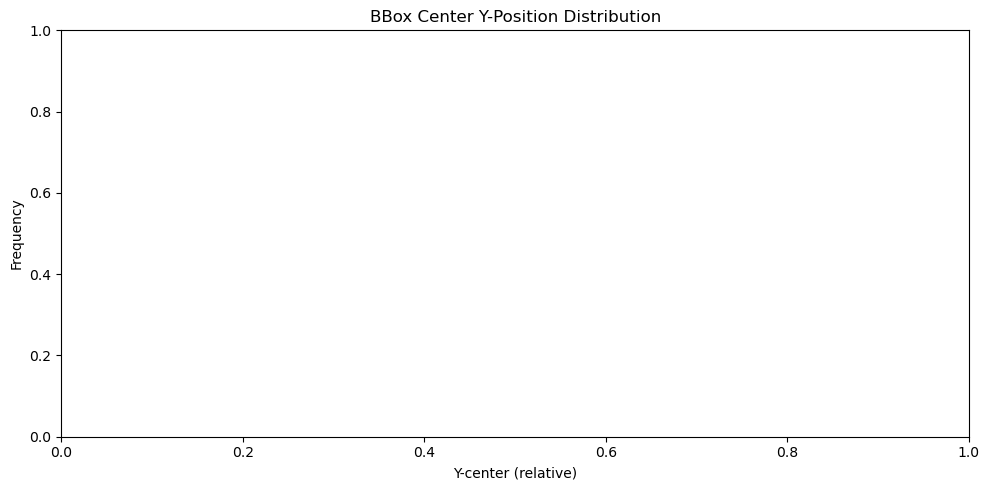

In [61]:
run_dataset_analysis(test_images_dir, test_labels_dir, CLASS_NAMES, test_report_dir, image_size=(640, 640))


--- Running analysis for images dataset ---
Checking alignment between images and labels in: C:\Users\ADITHYA\OneDrive\Kesari\dataset\val\images and C:\Users\ADITHYA\OneDrive\Kesari\dataset\val\labels
Images without labels: 0
Labels without images: 0
Analyzing bounding boxes in: C:\Users\ADITHYA\OneDrive\Kesari\dataset\val\labels


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 3703.96it/s]


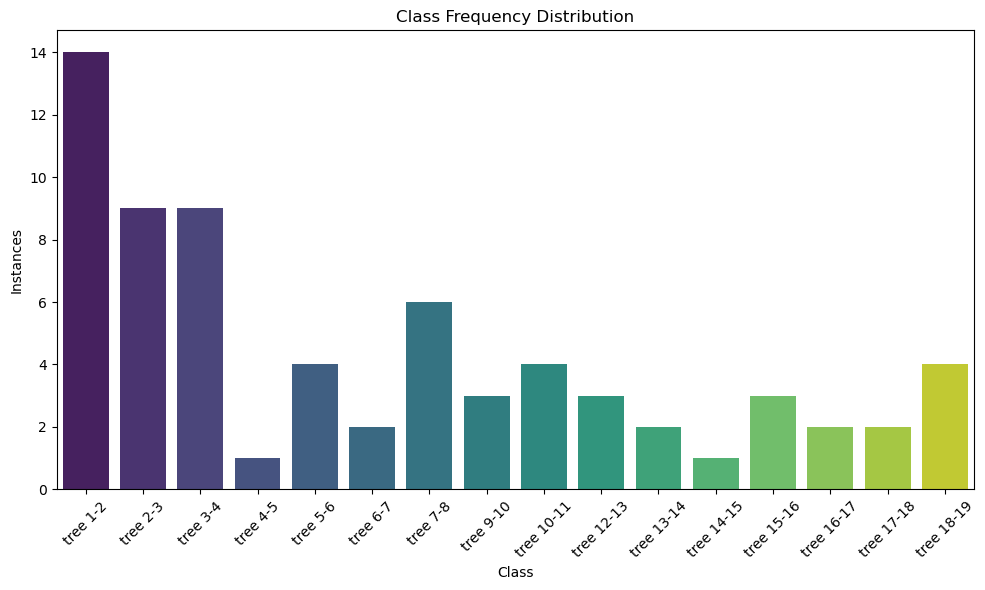

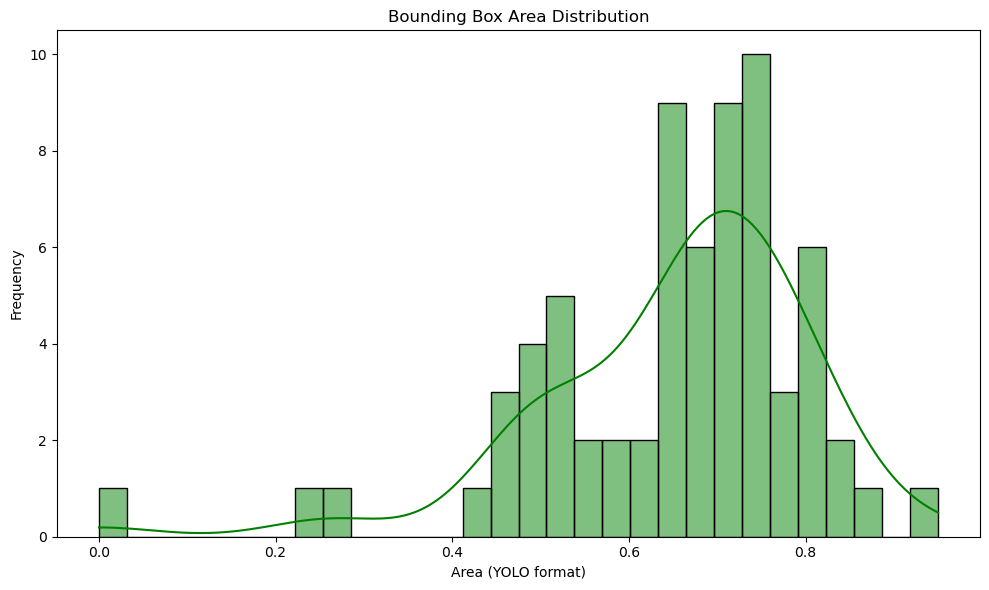

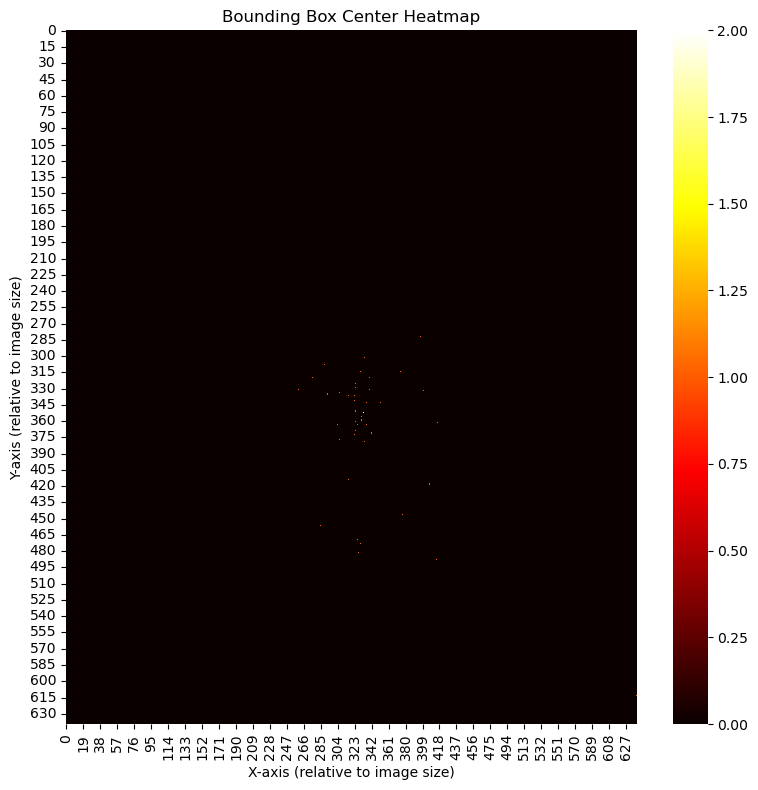

Computing channel statistics in: C:\Users\ADITHYA\OneDrive\Kesari\dataset\val\images


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 22.85it/s]


Channel Statistics:
Red   - Mean: 0.4456, Std: 0.0253
Green - Mean: 0.4513, Std: 0.0173
Blue  - Mean: 0.3659, Std: 0.0384


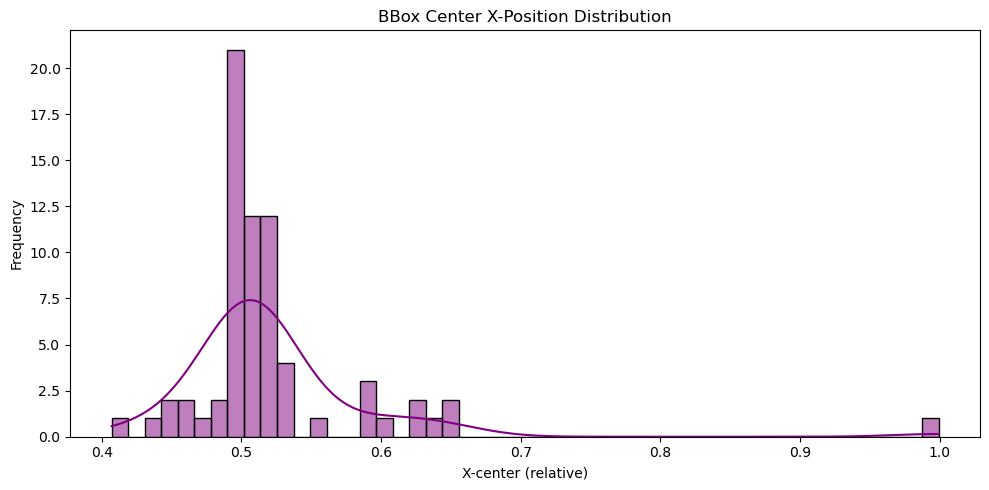

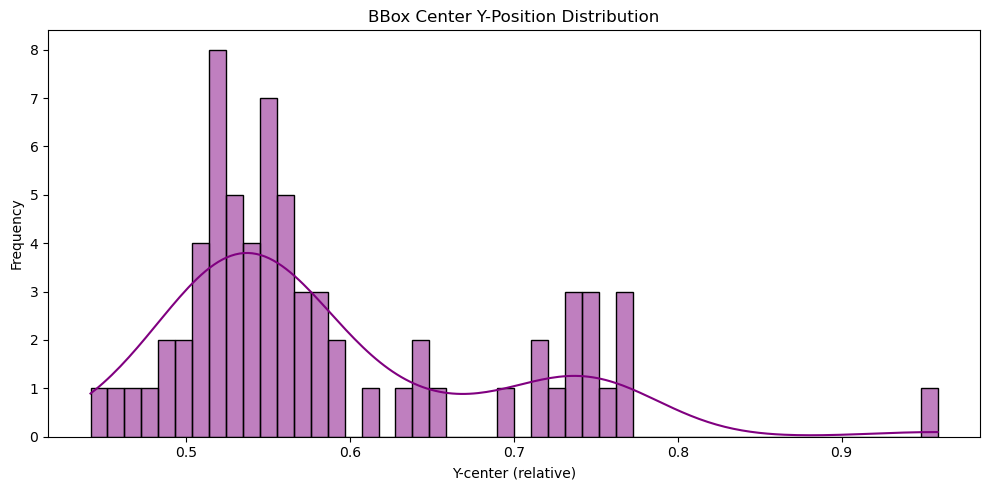

In [62]:
run_dataset_analysis(val_images_dir, val_labels_dir, CLASS_NAMES, valid_report_dir, image_size=(640, 640))